# Price elasticity and optimization

https://github.com/lzhang22/Price-elasticity-and-optimization/blob/master/price%20elasticity%20and%20optimization.ipynb

https://medium.com/geekculture/price-elasticity-of-demand-using-linear-regression-in-python-part-2-8adb654328e7

### Price Elasticity 
“How sensitive is Sales Demand, if product Price changes?” “How much my sales will increase, if I lower my price?”

It answers following questions:
1. Does sales demand changes, when the price changes?
2. How likely sales demand change when price changes?

<img src='https://miro.medium.com/max/2400/1*wqp9Ot6C6MwR_QFnwi69qg.png' width='600'>

In [1]:
import numpy as np
import pandas as pd

import random
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format

In [66]:
df = pd.read_csv('data.csv',  parse_dates=['InvoiceDate'])

In [67]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


## Field description
* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description**: Product (item) name. Nominal.
* **Quantity**: The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country**: Country name. Nominal, the name of the country where each customer resides.

In [68]:
print('The dataset has orders made from {} to {}'.format(min(df['InvoiceDate']),
                                                         max(df['InvoiceDate'])))

The dataset has orders made from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [69]:
print('There are %d items that do not have a category name.' %df['CustomerID'].isnull().sum())

There are 135080 items that do not have a category name.


In [70]:
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,"541,909.00","541,909.00"
mean,9.55,4.61
std,218.08,96.76
min,"-80,995.00","-11,062.06"
25%,1.00,1.25
50%,3.00,2.08
75%,10.00,4.13
max,"80,995.00","38,970.00"


Negative values of Quantity and UnitPrice indicate return orders. Will keep only positive Quantity and UnitPrice for current analysis.

In [71]:
df = df[(df['Quantity']>0)&(df['UnitPrice']>0)]

In [72]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [73]:
df[df['CustomerID'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom


Since customer id is not needed for this analysis, and quantity and unit price have no missing values, rows with missing values won't be removed.

In [74]:
def handle_missing_inplace(dataset): 
    dataset['Description'].fillna(value='missing', inplace=True) 
    dataset['CustomerID'].fillna(value='missing', inplace=True) 
    #df['Country'].replace('No description yet,''missing', inplace=True) 
    #df['item_description'].fillna(value='missing', inplace=True)

In [75]:
handle_missing_inplace(df)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   530104 non-null  object        
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.4+ MB


### Examining items data
Having a look at number of prices for each item to decide which items to use for price elasticity analysis. **We would want items that have had quite some variation in price and been sold in quite a large number of orders. TOP 200 items on orders**

CategoricalIndex(['85123A', '22423', '85099B', '47566', '20725', '84879',
                  '22720', '22197', '21212', '20727',
                  ...
                  '21481', '22456', '23243', '22173', '22147', '21523',
                  '21155', '23198', '23356', '23343'],
                 categories=['10002', '10080', '10120', '10123C', '10123G', '10124A', '10124G', '10125', ...], ordered=False, dtype='category', length=200)

In [63]:
df_items = df.groupby('StockCode')\
             .agg({'Description': 'first',
                   'UnitPrice': ['nunique', 'count', 'mean', 'min', 'max']})\
             .reset_index()

# rename columns - merge multi-level columns from agg
df_items.columns = [level1+level2.title() if level2!='' else level1\
                    for level1, level2 in df_items.columns ]

df_items.sort_values(by=['UnitPriceNunique', 'UnitPriceCount'],
                     ascending=False, inplace=True)

df_items.head(10)

,StockCode,DescriptionFirst,UnitPriceNunique,UnitPriceCount,UnitPriceMean,UnitPriceMin,UnitPriceMax
4059,DOT,DOTCOM POSTAGE,687,710,290.50,0.00,"4,505.17"
4060,M,Manual,260,571,375.57,0.00,"38,970.00"
4062,POST,POSTAGE,114,1256,36.93,0.00,"8,142.75"
4042,D,Discount,75,77,72.48,0.01,"1,867.86"
4063,S,SAMPLES,59,63,50.40,2.80,570.00
4037,AMAZONFEE,AMAZON FEE,30,34,"7,324.78",1.00,"17,836.46"
4039,BANK CHARGES,Bank Charges,26,37,202.86,0.00,"1,050.15"
2733,47566,PARTY BUNTING,16,1727,5.78,0.00,15.79
2924,79321,CHILLI LIGHTS,16,683,6.71,0.00,17.88
4041,CRUK,CRUK Commission,16,16,495.84,1.60,"1,100.44"


In [108]:
items_to_remove = ['DOTCOM POSTAGE', 'Manual', 'POSTAGE', 'Discount','SAMPLES','AMAZON FEE','Bank Charges']

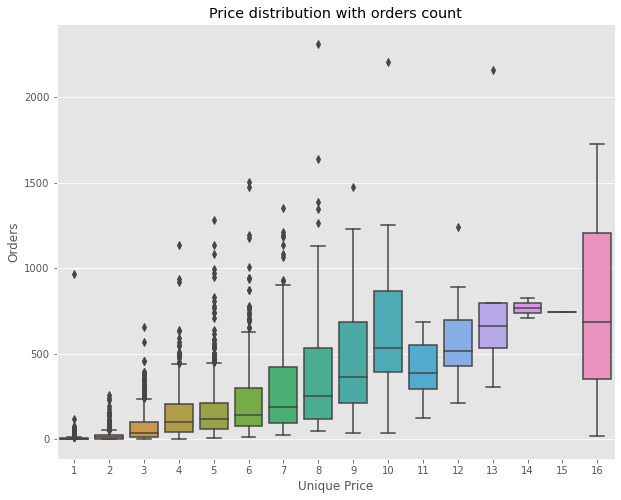

In [120]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_items[~df_items['DescriptionFirst'].isin(items_to_remove)].UnitPriceNunique
y_axis = df_items[~df_items['DescriptionFirst'].isin(items_to_remove)].UnitPriceCount
plt.figure(figsize = (10, 8))
ax = sns.boxplot(x=x_axis, y=y_axis)
plt.title('Price distribution with orders count')
plt.xlabel('Unique Price')
plt.ylabel('Orders')
plt.show()

<AxesSubplot:>

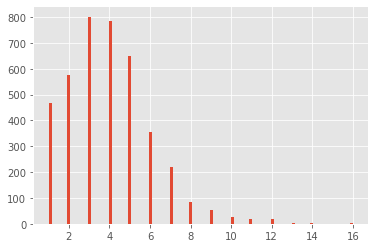

In [111]:
df_items[~df_items['DescriptionFirst'].isin(items_to_remove)].UnitPriceNunique.hist(bins=100)

For each item, quantity sold will be aggregated to get the total demand at each price for the entire year. Regression will then be used to estimate price elasticity of demand of each item. Given that for regression, *roughly 10 observations would be needed* to estimate a parameter, **the analysis would only use items with at least 10 prices.**

### Aggregating price and quantity for selected item

In [101]:
# # Remove non-item products
# items_to_remove = ['DOTCOM POSTAGE', 'Manual', 'POSTAGE']

# # Select top 200 items
# top_items = df[(~df['Description'].isin(items_to_remove))]['StockCode']\
#                 .value_counts().loc[lambda x: x.index != 'missing'].index[:100]

# # Select only item with at least 10 selling prices
# df_items_sub = df_items[(df_items['UnitPriceNunique']>=10)\
#                          &(df_items['StockCode'].isin(top_items))\
#                        ]



# # subset items with at least 10 unit prices
# df_sub = df[df['StockCode'].isin(df_items_sub['StockCode'].tolist())]\
#                            .reset_index(drop=True)\
#                            .drop(columns=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country'])

# # Get total quantity at each unit price for each item
# df_agg = df_sub.groupby(['StockCode', 'UnitPrice'])['Quantity']\
#                .sum()\
#                .reset_index()\
#                .rename(columns={'Quantity': 'TotalQuantity'})

In [114]:
df_items_sub = df_items[(df_items['UnitPriceNunique']>=5)\
                         &(~df_items['DescriptionFirst'].isin(items_to_remove))]

# subset items with at least 10 unit prices
df_sub = df[df['StockCode'].isin(df_items_sub['StockCode'].tolist())]\
                           .reset_index(drop=True)\
                           .drop(columns=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country'])

# Get total quantity at each unit price for each item
df_agg = df_sub.groupby(['StockCode', 'UnitPrice'])['Quantity']\
               .sum()\
               .reset_index()\
               .rename(columns={'Quantity': 'TotalQuantity'})

In [115]:
df_agg.StockCode.nunique()

1434

## Estimating price elasticity of demand

### Plot demand curve

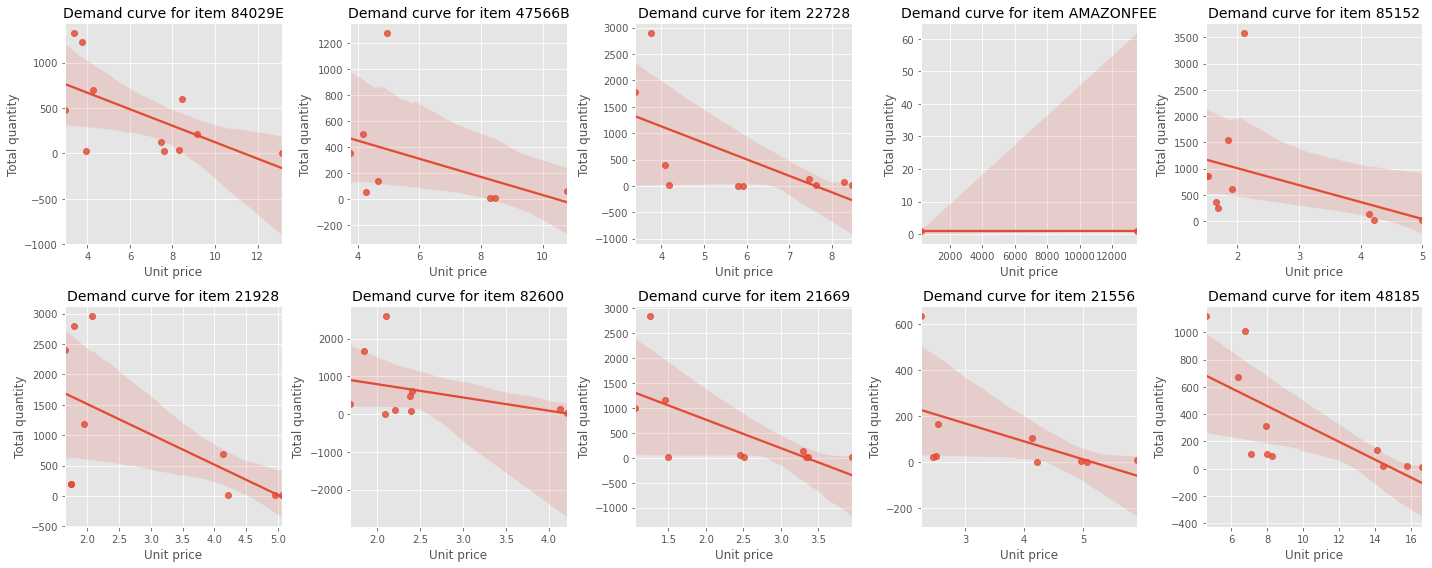

In [100]:
def plot_demand_curve(df, item_col, quantity_col, price_col, n=10):
    '''randomly select n items from a dataframe to plot each
       item's demand curve
    '''
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.ravel()
    
    # randomly choose n items to be plotted
    items_to_plot = random.sample(df[item_col].unique().tolist(), n)
    
    # plot demand vs unit price for the n items
    for i, item in enumerate(items_to_plot):
        sns.regplot(x=price_col, y=quantity_col, data=df[df[item_col]==item], ax=ax[i])
        ax[i].set_title('Demand curve for item '+item, fontsize=14)
        ax[i].set_xlabel('Unit price')
        ax[i].set_ylabel('Total quantity')
    plt.tight_layout()
    plt.show()

plot_demand_curve(df_agg, 'StockCode', 'TotalQuantity', 'UnitPrice')

### Fit linear regression to estimate elasticity
Assuming a linear relationship between price and quantity, we have the following linear regression function:

quantity = intercept + slope price, or Y = a + b X\
Price elasticity of demand, which is the percent change in quantity over percent change in price, can then be calculated using:

elasticity = (dY/Y) / (dX/X) = dY/dX (Y/X) = b (Y/X)\
That is, elasticity = slope * (mean quantity / mean price)

PE = (ΔQ/ΔP) * (P/Q)\
Where (ΔQ/ΔP) is determined by regression coefficient and P and Q will be our mean Price and mean Sales.



In [14]:
def get_elasticity(df, quantity_col, price_col):
    '''fits linear regression for one item, quantity_col is
       used as outcome variable and price_col as independent variable
       returns intercept, slope, p-value of regression, and also
       price elasticity 
    '''
    # regress quantity on price to estimate price elasticity
    reg_fit = smf.ols(formula=quantity_col+' ~ '+price_col, data=df).fit()
        
    # extract intercept slope and p-value from model parameters
    intercept = reg_fit.params['Intercept']
    tintercept, t_score = reg_fit.tvalues
    slope = reg_fit.params[price_col]
    p_value = reg_fit.pvalues.loc[price_col] 
    mean_price = np.mean(df[price_col])
    mean_quantity = np.mean(df[quantity_col])
    
    # calculate elasticity - slope*(mean price/mean quantity)
    elasticity = slope * (df[price_col].mean() / df[quantity_col].mean())
    
    return elasticity, t_score, p_value, slope, intercept, mean_price, mean_quantity

In [15]:
def get_multiple_elasticity(df, item_id_col, quantity_col, price_col):
    '''runs linear regression for multiple items in a df
       returns a separate df with item id, elasticity,
       p-value, and whether price is a significant predictor of 
       quantity
    '''
    elasticity_results = []
     
    for item_id in df[item_id_col].unique():
        elasticity = {}
        # subset rows with item_id
        df_single_item = df[df[item_id_col]==item_id]
        # store intercept slope and p-value in dict
        elasticity['StockCode'] = item_id
        elasticity['Elasticity'], elasticity['T_Score'], elasticity['PValue'], \
        elasticity['Slope'],  elasticity['Intercept'],\
        elasticity['AveragePrice'], elasticity['AverageQuantity']\
               = get_elasticity(df_single_item, quantity_col, price_col)
        elasticity_results.append(elasticity)
        
        df_elasticity = pd.DataFrame(elasticity_results).set_index('StockCode')
        # use p <.1 as cutoff for significance
        df_elasticity['Significant'] = df_elasticity['PValue'].apply(lambda x:
                                                                     'Yes' if x < 0.1 else 'No')
        
    return df_elasticity

In [16]:
# get elasticity for all items in df_agg
df_elasticity = get_multiple_elasticity(df_agg, 'StockCode', 'TotalQuantity', 'UnitPrice')
df_elasticity = df_elasticity.merge(df[['StockCode', 'Description']].drop_duplicates(), 
                                    on='StockCode', how='left')
df_elasticity.head(10)

,StockCode,Elasticity,T_Score,PValue,Slope,Intercept,AveragePrice,AverageQuantity,Significant,Description
0,17003,-1.38,-2.17,0.06,"-8,099.99","5,488.90",0.39,"2,305.60",Yes,BROCADE RING PURSE
1,20685,-2.16,-2.65,0.02,-64.77,993.95,10.49,314.77,Yes,DOORMAT RED RETROSPOT
2,20712,-1.03,-1.50,0.17,-342.39,"1,981.18",2.93,977.30,No,JUMBO BAG WOODLAND ANIMALS
3,21033,-1.31,-2.21,0.05,-60.06,371.73,3.51,161.08,Yes,JUMBO BAG CHARLIE AND LOLA TOYS
4,21166,-0.68,-0.58,0.57,-224.17,"1,243.06",2.24,740.29,No,COOK WITH WINE METAL SIGN
5,21174,-0.52,-0.34,0.74,-89.64,635.80,2.43,417.90,No,POTTERING IN THE SHED METAL SIGN
6,21175,-0.94,-1.02,0.33,-335.71,"1,823.31",2.63,940.38,No,GIN + TONIC DIET METAL SIGN
7,21175,-0.94,-1.02,0.33,-335.71,"1,823.31",2.63,940.38,No,GIN AND TONIC DIET METAL SIGN
8,21181,-0.71,-0.56,0.59,-344.88,"1,918.12",2.32,"1,118.64",No,PLEASE ONE PERSON METAL SIGN
9,21481,-2.51,-5.18,0.00,-130.24,"1,056.32",5.80,301.18,Yes,FAWN BLUE HOT WATER BOTTLE


* **Elasticity**: price elasticity per product
* **T_score**: equals to t-stats, which indicates the significance of the findings. The closer is to 0, the more likely there is no significance. The greater the t-stats, whether positive or negative, the greater the significance of the findings
* **PValue**: tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis
* **Slope** (coefficient):is the ratio of the “price change” to the “quantity sold change” between (any) two distinct points on a line
* **Intercept**: equals the quantity of X when all other variables = 0
* **AveragePrice**: average price per product
* **AverageQuantity**: average quantity sold per product

### Visualizing price elasticity
Plot elasticity of 10 most elastic and 10 most inelastic items

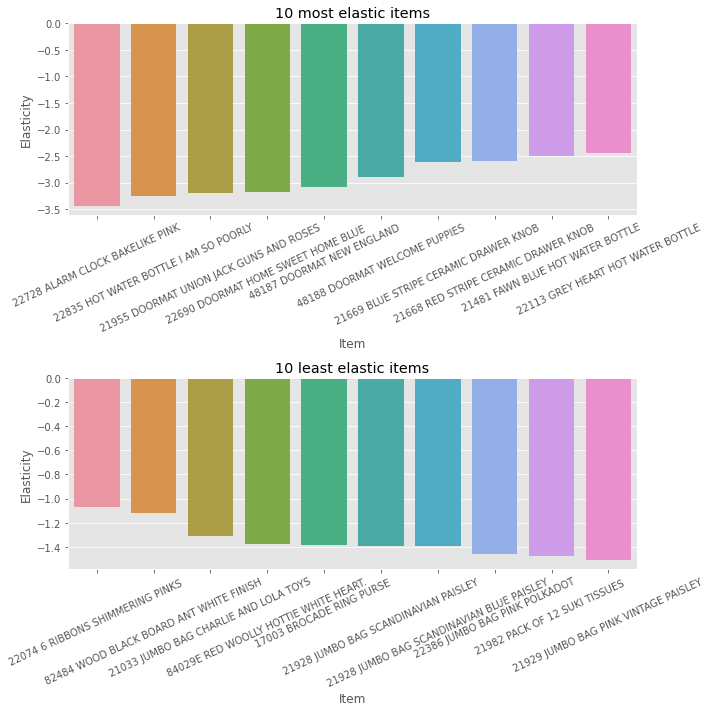

In [17]:
# subset items with significant p-value
df_elasticity = df_elasticity[df_elasticity['Significant']=='Yes']
df_elasticity['Item'] = df_elasticity[['StockCode', 'Description']]\
                                     .apply(lambda x: ' '.join(x), axis=1)

# make df for most and least elastic items
df_most_elastic = df_elasticity.sort_values(by='Elasticity')[:10]
df_least_elastic = df_elasticity.sort_values(by='Elasticity',
                                             ascending=False)[:10]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(x='Item', y='Elasticity', data=df_most_elastic, ax=axes[0])
axes[0].set_title('10 most elastic items')
sns.barplot(x='Item', y='Elasticity', data=df_least_elastic, ax=axes[1])
axes[1].set_title('10 least elastic items')
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(25)
plt.tight_layout()
plt.show()

Overall, items in this dataset are quite price elastic. The absolute values of even the least elastic items are greater than 1. This makes sense given that this dataset mainly contains small, non-necessity retail items.

In [18]:
def divergent_plot(df, values_column, ylabel, xlabel):

    #Divergent plot
    df['ranking'] = df[values_column].rank( ascending = True).astype(int)
    df.sort_values(values_column, ascending =False, inplace = True)
    plt.figure(figsize = (12,5), dpi = 80)
    plt.hlines(y = df['ranking'] , xmin = 0, xmax = df[values_column], alpha = 0.5, linewidth = 3)
    
    #Add elasticity labels
    for x, y, tex in zip(df[values_column], df['ranking'] , df[values_column]):
        plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':10})
        
    
    # Axis and title
    plt.gca().set(ylabel= ylabel, xlabel= xlabel)
    plt.yticks(df['ranking'])
    plt.title(values_column , fontdict={'size':13})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
            
    
    #Adjust Ranking column and print dataframe
    pd.set_option('display.width', 4000)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    df = df.iloc[:,:3]
    df.set_index('ranking', inplace=True)
    display(df)

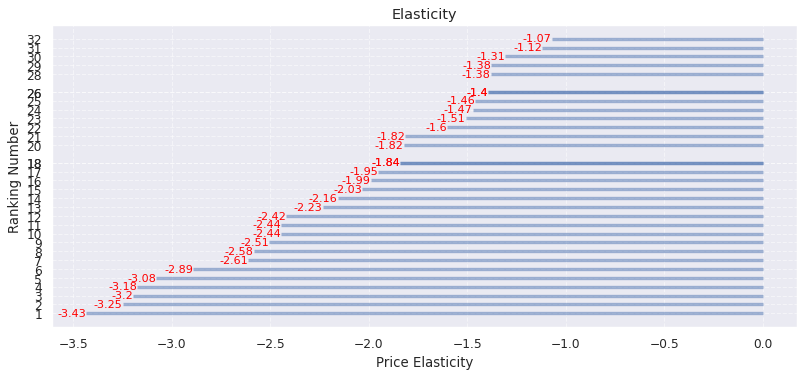

,StockCode,Elasticity
ranking,,
32,22074,-1.071158
31,82484,-1.121405
30,21033,-1.307709
29,84029E,-1.379442
28,17003,-1.380680
26,21928,-1.395336
26,21928,-1.395336
25,22386,-1.460990
24,21982,-1.472283


In [17]:
pe_plot = divergent_plot(df_elasticity, 'Elasticity', 'Ranking Number', 'Price Elasticity')

### A 10% price decrease in StockCode 22728, it increases sales demand by 34.34% or a 10% price increase in StockCode 22728, it decreases sales demand by 22.2%

Elasticities between 0- 1 are considered inelastic, as a result the products from rank 9 to 15 are inelastic.

Negative Price Elasticities are located from rank 1 to 8 and this would tell us the likelihood of when price decreases how likely sales demand would increase or vice versa.


## Price optimization
The dataset doesn't include cost information. Synthetic unit cost - 80% of mean price of each item will be used for price optimization.

In [19]:
# calculate unit cost (0.8*mean unit price) and add to elasticity df
df_elasticity = df_agg.groupby('StockCode')['UnitPrice']\
                      .agg(lambda x: x.mean()*0.8)\
                      .reset_index()\
                      .rename(columns={'UnitPrice': 'UnitCost'})\
                      .merge(df_elasticity, on='StockCode')

### Calculate price that maximizes profit for each item
We have the following functions for quantity and profit:

**quantity = intercept + slope * unit price \
profit = (unit price - unit cost) * quantity**

therefore,\
**profit = (unit price - unit cost) (intercept + slope unit price)**

To calculate profit-maximizing price, we would differentiate the profit function and make the derivative equal to 0\
Solving the derivative = 0 will give us:\
**profit-maximizing price = (-intercept + slope unit cost) / (2 slope)**

In [20]:
def get_optimal_price(row):
    '''calculates profit maximizing price using marginal cost and elasticity
    '''
    return (-row['Intercept']+row['Slope']*row['UnitCost'])/(2*row['Slope'])
    
df_elasticity['OptimalPrice'] = df_elasticity.apply(get_optimal_price, axis=1)

### Plot estimated profit curve
The following function will be used to plot profit curve using estimated elasticity and unit price
profit = (unit price - unit cost) (intercept + slope unit price)

In [21]:
def plot_estimated_profit(df, n=10):
    '''randomly selects n items from df to plot
       estimated profit curve for each item,
       df needs to have StockCode, UnitCost, Intercept, 
       Slope, and OptimalPrice columns
    '''
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.ravel()
    
    # randomly choose n items to be plotted
    items_to_plot = random.sample(df['StockCode'].unique().tolist(), n)
    
    # for each item in the randomly chosen list
    for i, item in enumerate(items_to_plot):
        price = np.linspace(0, 15, 1000)
        # extract the parameters, unit cost, and optimal price of the item
        cols = ['UnitCost', 'Intercept', 'Slope', 'OptimalPrice']
        row = df[df['StockCode']==item][cols].values
        # estimated profit function
        est_profit = (price - row[0][0]) * (row[0][1] + row[0][2] * price)
        
        # plot estimated profit against price
        ax[i].plot(price, est_profit)
        ax[i].axvline(x=row[0][3], c='k')
        ax[i].set_title('Estimated profit for item '+item, fontsize=14)
        ax[i].set_xlabel('Price')
        ax[i].set_ylabel('Profit')
    plt.tight_layout()
    plt.show()

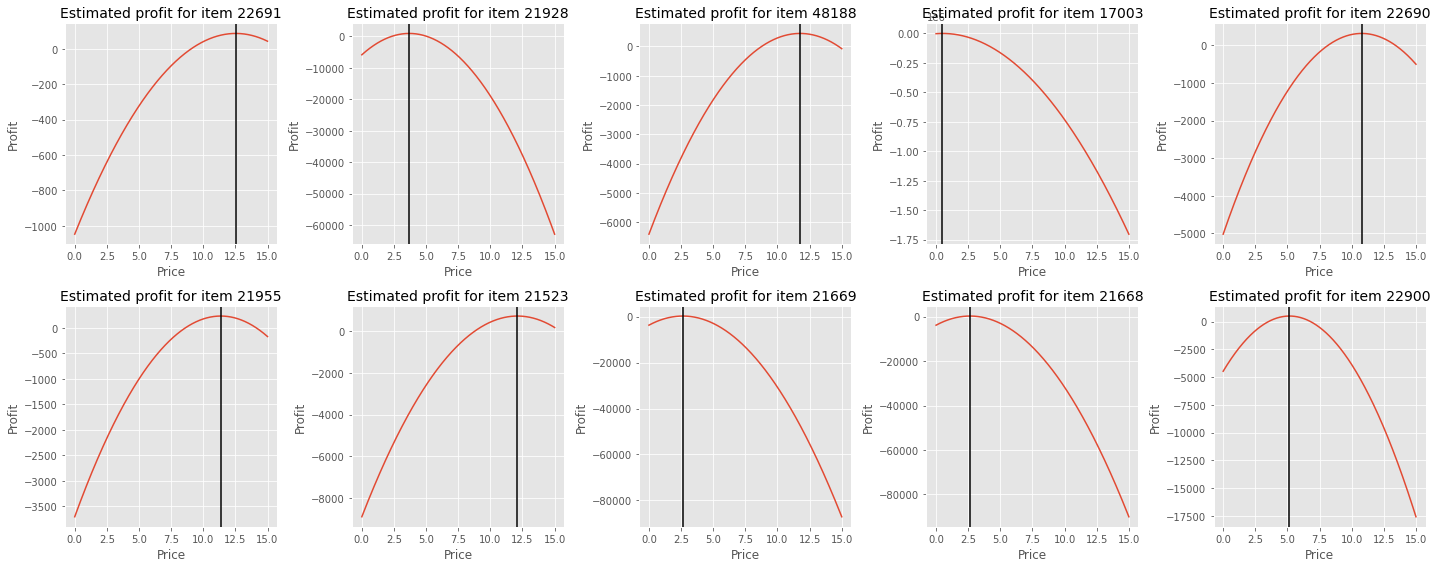

In [22]:
plot_estimated_profit(df_elasticity)

It is interesting to see different maximum profits for different items.

### Possible future steps
The current analysis uses only an item's own price to predict its demand. It would be good to include other features that could influence demand for example, promotional events and holidays if such features were available. Also, the demand of one item can be influenced by the prices of other items sold on the retail platform. With more data, it would be good to estimate cross price elasticity between items - how price in one item affects quantity sold of another item. It would then be possible to optimize prices with the objective to maximize total profit given the own and cross price elasticity of all the items.

https://github.com/PrachiKharat/E-commerce-Price-Elasticity-Demand-Analysis/blob/main/Price_Elasticity_of_Demand.ipynb